In [17]:
#自动重载
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2
from PIL import ImageEnhance
from utils import mask2yolo,make_pic
from tqdm import tqdm
mainpath = "./datasets/"
bg_path = "bg/"
fg_path = "fg_2/"
masks_path = "masks/"
fgs = os.listdir(mainpath+fg_path)
bgs = os.listdir(mainpath+bg_path)
masks = os.listdir(mainpath+masks_path)

In [2]:
test_fg_list = [mainpath+fg_path+fg for fg in fgs[:2]]
test_bg = mainpath+bg_path+bgs[0]
test_mask_list = [mainpath+masks_path+mask for mask in masks[:2]]
mixed_pic,mixed_mask,target_cnt = make_pic(test_fg_list,test_bg,test_mask_list)

1


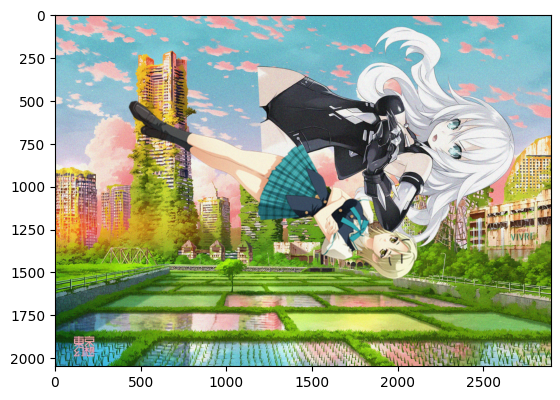

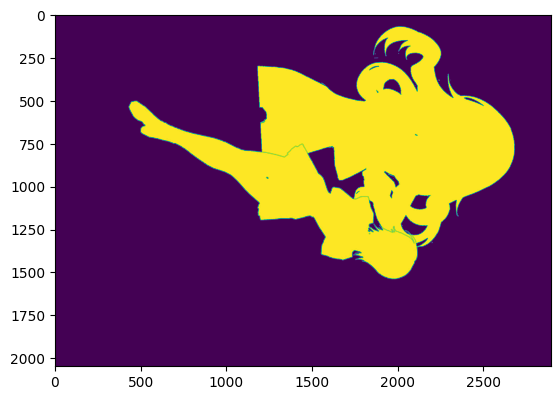

In [6]:
# 打印出来看看
print(target_cnt)
plt.imshow(mixed_pic)
plt.show()
mixed_mask = np.array(mixed_mask)
plt.imshow(mixed_mask)
plt.show()

[23  7]
2


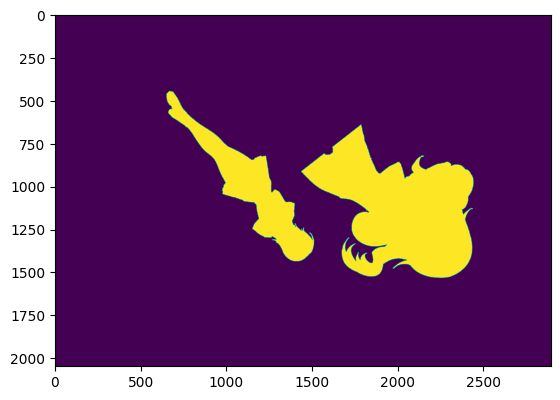

In [68]:
yolo, mas = mask2yolo(mixed_mask,target_cnt,show=True)
plt.imshow(mas)

In [22]:
# 为每个fg都生成一个yolo的
# 生成的yolo格式的mask保存在./datasets/masks_yolo/下
# 生成的叠加后的图片保存在./datasets/mixed_pic/下
# 改成tqdm的形式，可以看到进度条
if not os.path.exists(mainpath+"masks_yolo/"):
    os.mkdir(mainpath+"masks_yolo/")
if not os.path.exists(mainpath+"mixed_pic/"):
    os.mkdir(mainpath+"mixed_pic/")
if not  os.path.exists(mainpath+"mixed_mask/"):
    os.mkdir(mainpath+"mixed_mask/")

max_target_num = 4
pic_num = 1000
for n in tqdm(range(pic_num), desc='Processing images'):
    target_num = np.random.randint(1,max_target_num)
    choice = np.random.choice(len(fgs),target_num)
    fg = []
    mask = []
    for i in choice:
        fg.append(fgs[i])
        mask.append(masks[i])
    bg_cur = bgs[np.random.randint(0,len(bgs))]
    fg_list = [mainpath+fg_path+i for i in fg]
    bg = mainpath+bg_path+bg_cur
    mask_list = [mainpath+masks_path+i for i in mask]
    mixed_pic, mixed_mask, target_cnt = make_pic(fg_list, bg, mask_list)
    filename = ""
    for i in fg:
        filename += i[:-4]+"_"
    mixed_pic.save(mainpath+"mixed_pic/"+filename+"_"+bg_cur[:-4]+".jpg")
    mixed_mask.save(mainpath+"mixed_mask/"+filename+"_"+bg_cur[:-4]+".jpg")
    yolo = mask2yolo(mixed_mask, target_cnt, show=False)
    with open(mainpath+"masks_yolo/"+filename+"_"+bg_cur[:-4]+".txt","w") as f:
        f.write(yolo[0])
    

Processing images:   0%|          | 1/1000 [00:01<28:29,  1.71s/it]

[ 0 19]
2


Processing images:   0%|          | 2/1000 [00:03<26:36,  1.60s/it]

[60 23]
2


Processing images:   0%|          | 3/1000 [00:04<20:22,  1.23s/it]

[104   4]
2


Processing images:   0%|          | 4/1000 [00:04<18:41,  1.13s/it]

[ 0 21]
2


Processing images:   0%|          | 5/1000 [00:06<23:57,  1.44s/it]

[4]
1


Processing images:   1%|          | 6/1000 [00:08<26:14,  1.58s/it]

[24  1]
2


Processing images:   1%|          | 7/1000 [00:09<21:15,  1.28s/it]

[3]
1


Processing images:   1%|          | 8/1000 [00:09<16:09,  1.02it/s]

[0]
1


Processing images:   1%|          | 9/1000 [00:10<12:36,  1.31it/s]

[0]
1


Processing images:   1%|          | 10/1000 [00:10<12:42,  1.30it/s]

[0]
1


Processing images:   1%|          | 11/1000 [00:11<13:35,  1.21it/s]

[1]
1


Processing images:   1%|          | 12/1000 [00:12<14:15,  1.15it/s]

[0]
1


Processing images:   1%|▏         | 13/1000 [00:14<16:15,  1.01it/s]

[2]
1


Processing images:   1%|▏         | 14/1000 [00:16<21:19,  1.30s/it]

[6]
1


Processing images:   2%|▏         | 15/1000 [00:18<25:19,  1.54s/it]

[ 2 23]
2


Processing images:   2%|▏         | 16/1000 [00:18<21:13,  1.29s/it]

[1]
1


Processing images:   2%|▏         | 17/1000 [00:20<24:01,  1.47s/it]

[11]
1


Processing images:   2%|▏         | 18/1000 [00:21<20:09,  1.23s/it]

[2]
1


Processing images:   2%|▏         | 19/1000 [00:23<22:11,  1.36s/it]

[0]
1


Processing images:   2%|▏         | 20/1000 [00:25<25:32,  1.56s/it]

[ 0 45]
2


Processing images:   2%|▏         | 21/1000 [00:27<27:02,  1.66s/it]

[2]
1


Processing images:   2%|▏         | 22/1000 [00:27<22:46,  1.40s/it]

[0]
1


Processing images:   2%|▏         | 23/1000 [00:29<23:47,  1.46s/it]

[0]
1


Processing images:   2%|▏         | 24/1000 [00:30<20:07,  1.24s/it]

[1]
1


Processing images:   2%|▎         | 25/1000 [00:30<16:14,  1.00it/s]

[0]
1


Processing images:   3%|▎         | 26/1000 [00:34<28:57,  1.78s/it]

[ 1  6 30]
3


Processing images:   3%|▎         | 27/1000 [00:36<30:24,  1.87s/it]

[14 39]
2


Processing images:   3%|▎         | 28/1000 [00:37<25:50,  1.60s/it]

[1]
1


Processing images:   3%|▎         | 29/1000 [00:38<22:12,  1.37s/it]

[50]
1


Processing images:   3%|▎         | 30/1000 [00:41<29:39,  1.83s/it]

[ 0 18]
2


Processing images:   3%|▎         | 31/1000 [00:41<24:50,  1.54s/it]

[0]
1


Processing images:   3%|▎         | 32/1000 [00:44<28:13,  1.75s/it]

[ 0 15]
2


Processing images:   3%|▎         | 33/1000 [00:45<26:22,  1.64s/it]

[2]
1


Processing images:   3%|▎         | 34/1000 [00:47<27:13,  1.69s/it]

[23]
1


Processing images:   4%|▎         | 35/1000 [00:48<24:29,  1.52s/it]

[1]
1


Processing images:   4%|▎         | 36/1000 [00:49<21:54,  1.36s/it]

[0]
1


Processing images:   4%|▎         | 37/1000 [00:50<19:44,  1.23s/it]

[2]
1


Processing images:   4%|▍         | 38/1000 [00:50<15:57,  1.00it/s]

[2]
1


Processing images:   4%|▍         | 39/1000 [00:53<24:28,  1.53s/it]

[2]
1


Processing images:   4%|▍         | 40/1000 [00:54<21:26,  1.34s/it]

[1]
1


Processing images:   4%|▍         | 41/1000 [00:57<28:29,  1.78s/it]

[ 3 12]
2


Processing images:   4%|▍         | 42/1000 [00:58<23:49,  1.49s/it]

[1]
1


Processing images:   4%|▍         | 43/1000 [00:59<22:35,  1.42s/it]

[2]
1


Processing images:   4%|▍         | 44/1000 [01:00<19:49,  1.24s/it]

[0]
1


Processing images:   4%|▍         | 45/1000 [01:02<23:03,  1.45s/it]

[ 3 30]
2


Processing images:   5%|▍         | 46/1000 [01:03<24:56,  1.57s/it]

[2]
1


Processing images:   5%|▍         | 47/1000 [01:05<23:09,  1.46s/it]

[56]
1


Processing images:   5%|▍         | 48/1000 [01:07<26:34,  1.67s/it]

[57  3]
2


Processing images:   5%|▍         | 49/1000 [01:08<26:12,  1.65s/it]

[0]
1


Processing images:   5%|▌         | 50/1000 [01:10<24:34,  1.55s/it]

[19]
1


Processing images:   5%|▌         | 51/1000 [01:11<23:42,  1.50s/it]

[8]
1


Processing images:   5%|▌         | 52/1000 [01:13<24:53,  1.58s/it]

[2]
1


Processing images:   5%|▌         | 53/1000 [01:13<19:02,  1.21s/it]

[73]
1


Processing images:   5%|▌         | 54/1000 [01:15<22:00,  1.40s/it]

[8]
1


Processing images:   6%|▌         | 55/1000 [01:16<19:17,  1.22s/it]

[8]
1


Processing images:   6%|▌         | 56/1000 [01:17<17:09,  1.09s/it]

[2]
1


Processing images:   6%|▌         | 57/1000 [01:18<20:21,  1.30s/it]

[0 8]
2


Processing images:   6%|▌         | 58/1000 [01:20<22:29,  1.43s/it]

[10]
1


Processing images:   6%|▌         | 59/1000 [01:22<23:42,  1.51s/it]

[7]
1


Processing images:   6%|▌         | 60/1000 [01:23<23:20,  1.49s/it]

[1]
1


Processing images:   6%|▌         | 61/1000 [01:25<24:53,  1.59s/it]

[33]
1


Processing images:   6%|▌         | 62/1000 [01:26<21:55,  1.40s/it]

[4]
1


Processing images:   6%|▋         | 63/1000 [01:32<41:38,  2.67s/it]

[ 0 32  6]
3


Processing images:   6%|▋         | 64/1000 [01:33<37:17,  2.39s/it]

[5]
1


Processing images:   6%|▋         | 65/1000 [01:36<38:58,  2.50s/it]

[10  0]
2


Processing images:   7%|▋         | 66/1000 [01:37<31:58,  2.05s/it]

[0]
1


Processing images:   7%|▋         | 67/1000 [01:39<29:05,  1.87s/it]

[20]
1


Processing images:   7%|▋         | 68/1000 [01:40<27:29,  1.77s/it]

[15]
1


Processing images:   7%|▋         | 69/1000 [01:42<28:43,  1.85s/it]

[4]
1


Processing images:   7%|▋         | 70/1000 [01:43<25:04,  1.62s/it]

[11  3]
2


Processing images:   7%|▋         | 71/1000 [01:44<20:15,  1.31s/it]

[0]
1


Processing images:   7%|▋         | 72/1000 [01:45<17:54,  1.16s/it]

[5]
1


Processing images:   7%|▋         | 73/1000 [01:45<13:43,  1.13it/s]

[0]
1


Processing images:   7%|▋         | 74/1000 [01:46<12:54,  1.20it/s]

[12]
1


Processing images:   8%|▊         | 75/1000 [01:46<12:08,  1.27it/s]

[0]
1


Processing images:   8%|▊         | 76/1000 [01:49<20:13,  1.31s/it]

[ 61 123]
2


Processing images:   8%|▊         | 77/1000 [01:51<23:40,  1.54s/it]

[91]
1


Processing images:   8%|▊         | 78/1000 [01:52<19:44,  1.28s/it]

[0]
1


Processing images:   8%|▊         | 79/1000 [01:52<16:19,  1.06s/it]

[2]
1


Processing images:   8%|▊         | 80/1000 [01:54<20:50,  1.36s/it]

[ 0 34]
2


Processing images:   8%|▊         | 81/1000 [01:58<32:58,  2.15s/it]

[2]
1


Processing images:   8%|▊         | 82/1000 [01:58<23:53,  1.56s/it]

[1]
1


Processing images:   8%|▊         | 83/1000 [02:01<26:07,  1.71s/it]

[3]
1


Processing images:   8%|▊         | 84/1000 [02:02<24:15,  1.59s/it]

[0]
1


Processing images:   8%|▊         | 85/1000 [02:02<19:52,  1.30s/it]

[0]
1


Processing images:   9%|▊         | 86/1000 [02:05<25:10,  1.65s/it]

[2]
1


Processing images:   9%|▊         | 87/1000 [02:07<26:50,  1.76s/it]

[0]
1


Processing images:   9%|▉         | 88/1000 [02:08<21:16,  1.40s/it]

[0]
1


Processing images:   9%|▉         | 89/1000 [02:09<19:25,  1.28s/it]

[0]
1


Processing images:   9%|▉         | 90/1000 [02:09<17:53,  1.18s/it]

[1]
1


Processing images:   9%|▉         | 91/1000 [02:10<15:24,  1.02s/it]

[0]
1


Processing images:   9%|▉         | 92/1000 [02:13<23:57,  1.58s/it]

[0]
1


Processing images:   9%|▉         | 93/1000 [02:14<23:23,  1.55s/it]

[0]
1


Processing images:   9%|▉         | 94/1000 [02:16<25:13,  1.67s/it]

[1]
1


Processing images:  10%|▉         | 95/1000 [02:17<20:44,  1.37s/it]

[2]
1


Processing images:  10%|▉         | 96/1000 [02:18<18:12,  1.21s/it]

[2]
1


Processing images:  10%|▉         | 97/1000 [02:19<16:35,  1.10s/it]

[1]
1


Processing images:  10%|▉         | 98/1000 [02:20<17:08,  1.14s/it]

[0]
1


Processing images:  10%|▉         | 99/1000 [02:21<16:46,  1.12s/it]

[0]
1


Processing images:  10%|█         | 100/1000 [02:24<24:56,  1.66s/it]

[46  1]
2


Processing images:  10%|█         | 101/1000 [02:26<27:20,  1.82s/it]

[0]
1


Processing images:  10%|█         | 102/1000 [02:28<26:44,  1.79s/it]

[ 0 43]
2


Processing images:  10%|█         | 103/1000 [02:29<21:52,  1.46s/it]

[0]
1


Processing images:  10%|█         | 104/1000 [02:30<23:24,  1.57s/it]

[1]
1


Processing images:  10%|█         | 105/1000 [02:32<21:44,  1.46s/it]

[4]
1


Processing images:  11%|█         | 106/1000 [02:33<19:22,  1.30s/it]

[5]
1


Processing images:  11%|█         | 107/1000 [02:33<16:27,  1.11s/it]

[2]
1


Processing images:  11%|█         | 108/1000 [02:35<18:27,  1.24s/it]

[ 5 16]
2


Processing images:  11%|█         | 109/1000 [02:36<17:46,  1.20s/it]

[0]
1


Processing images:  11%|█         | 110/1000 [02:37<17:40,  1.19s/it]

[11]
1


Processing images:  11%|█         | 111/1000 [02:38<18:09,  1.23s/it]

[0 6]
2


Processing images:  11%|█         | 112/1000 [02:40<21:49,  1.48s/it]

[25  5]
2


Processing images:  11%|█▏        | 113/1000 [02:42<23:45,  1.61s/it]

[0]
1


Processing images:  11%|█▏        | 114/1000 [02:44<24:03,  1.63s/it]

[0]
1


Processing images:  12%|█▏        | 115/1000 [02:45<21:21,  1.45s/it]

[0]
1


Processing images:  12%|█▏        | 116/1000 [02:46<20:54,  1.42s/it]

[248]
1


Processing images:  12%|█▏        | 117/1000 [02:47<17:00,  1.16s/it]

[7]
1


Processing images:  12%|█▏        | 118/1000 [02:49<21:35,  1.47s/it]

[ 2 31]
2


Processing images:  12%|█▏        | 119/1000 [02:50<17:30,  1.19s/it]

[0]
1


Processing images:  12%|█▏        | 120/1000 [02:50<15:28,  1.06s/it]

[0]
1


Processing images:  12%|█▏        | 121/1000 [02:53<22:21,  1.53s/it]

[1]
1


Processing images:  12%|█▏        | 122/1000 [02:54<19:34,  1.34s/it]

[0]
1


Processing images:  12%|█▏        | 123/1000 [02:55<18:12,  1.25s/it]

[0]
1


Processing images:  12%|█▏        | 124/1000 [02:55<15:08,  1.04s/it]

[0]
1


Processing images:  12%|█▎        | 125/1000 [02:56<13:36,  1.07it/s]

[0]
1


Processing images:  13%|█▎        | 126/1000 [02:58<18:14,  1.25s/it]

[2]
1


Processing images:  13%|█▎        | 127/1000 [03:00<20:08,  1.38s/it]

[0]
1


Processing images:  13%|█▎        | 128/1000 [03:00<16:44,  1.15s/it]

[2]
1


Processing images:  13%|█▎        | 129/1000 [03:01<14:54,  1.03s/it]

[0]
1


Processing images:  13%|█▎        | 130/1000 [03:03<19:57,  1.38s/it]

[9 1]
2


Processing images:  13%|█▎        | 131/1000 [03:05<20:39,  1.43s/it]

[68  0]
2


Processing images:  13%|█▎        | 132/1000 [03:06<17:25,  1.20s/it]

[0]
1


Processing images:  13%|█▎        | 133/1000 [03:07<18:59,  1.31s/it]

[8]
1


Processing images:  13%|█▎        | 134/1000 [03:08<16:46,  1.16s/it]

[0]
1


Processing images:  14%|█▎        | 135/1000 [03:09<17:52,  1.24s/it]

[53]
1


Processing images:  14%|█▎        | 136/1000 [03:10<13:35,  1.06it/s]

[2]
1


Processing images:  14%|█▎        | 137/1000 [03:12<18:49,  1.31s/it]

[0]
1


Processing images:  14%|█▍        | 138/1000 [03:13<16:45,  1.17s/it]

[0]
1


Processing images:  14%|█▍        | 139/1000 [03:14<15:16,  1.06s/it]

[2]
1


Processing images:  14%|█▍        | 140/1000 [03:15<18:25,  1.29s/it]

[7]
1


Processing images:  14%|█▍        | 141/1000 [03:16<16:33,  1.16s/it]

[0]
1


Processing images:  14%|█▍        | 142/1000 [03:17<15:09,  1.06s/it]

[0]
1


Processing images:  14%|█▍        | 143/1000 [03:18<13:08,  1.09it/s]

[0]
1


Processing images:  14%|█▍        | 144/1000 [03:19<14:13,  1.00it/s]

[5]
1


Processing images:  14%|█▍        | 145/1000 [03:21<18:12,  1.28s/it]

[8]
1


Processing images:  15%|█▍        | 146/1000 [03:23<20:45,  1.46s/it]

[5]
1


Processing images:  15%|█▍        | 147/1000 [03:23<18:16,  1.29s/it]

[2]
1


Processing images:  15%|█▍        | 148/1000 [03:24<14:31,  1.02s/it]

[1]
1


Processing images:  15%|█▍        | 149/1000 [03:25<13:36,  1.04it/s]

[2]
1


Processing images:  15%|█▌        | 150/1000 [03:26<14:20,  1.01s/it]

[0]
1


Processing images:  15%|█▌        | 151/1000 [03:26<11:18,  1.25it/s]

[1]
1


Processing images:  15%|█▌        | 152/1000 [03:27<10:45,  1.31it/s]

[1]
1


Processing images:  15%|█▌        | 153/1000 [03:28<10:27,  1.35it/s]

[39]
1


Processing images:  15%|█▌        | 154/1000 [03:29<13:48,  1.02it/s]

[ 3 20]
2


Processing images:  16%|█▌        | 155/1000 [03:31<17:51,  1.27s/it]

[1]
1


Processing images:  16%|█▌        | 156/1000 [03:34<23:10,  1.65s/it]

[1]
1


Processing images:  16%|█▌        | 157/1000 [03:35<22:34,  1.61s/it]

[1]
1


Processing images:  16%|█▌        | 158/1000 [03:36<19:27,  1.39s/it]

[0]
1


Processing images:  16%|█▌        | 159/1000 [03:37<17:22,  1.24s/it]

[2]
1


Processing images:  16%|█▌        | 160/1000 [03:38<16:39,  1.19s/it]

[1]
1


Processing images:  16%|█▌        | 161/1000 [03:38<13:51,  1.01it/s]

[0]
1


Processing images:  16%|█▌        | 162/1000 [03:41<22:13,  1.59s/it]

[ 4 76]
2


Processing images:  16%|█▋        | 163/1000 [03:42<18:39,  1.34s/it]

[3]
1


Processing images:  16%|█▋        | 164/1000 [03:43<16:48,  1.21s/it]

[1]
1


Processing images:  16%|█▋        | 165/1000 [03:45<20:05,  1.44s/it]

[78  1]
2


Processing images:  17%|█▋        | 166/1000 [03:46<16:12,  1.17s/it]

[0]
1


Processing images:  17%|█▋        | 167/1000 [03:47<15:57,  1.15s/it]

[5]
1


Processing images:  17%|█▋        | 168/1000 [03:49<21:45,  1.57s/it]

[7 0]
2


Processing images:  17%|█▋        | 169/1000 [03:50<18:28,  1.33s/it]

[1]
1


Processing images:  17%|█▋        | 170/1000 [03:51<18:37,  1.35s/it]

[1]
1


Processing images:  17%|█▋        | 171/1000 [03:52<14:12,  1.03s/it]

[0]
1


Processing images:  17%|█▋        | 172/1000 [03:53<15:26,  1.12s/it]

[0]
1


Processing images:  17%|█▋        | 173/1000 [03:54<13:35,  1.01it/s]

[3]
1


Processing images:  17%|█▋        | 174/1000 [03:56<19:19,  1.40s/it]

[1]
1


Processing images:  18%|█▊        | 175/1000 [03:58<20:54,  1.52s/it]

[4]
1


Processing images:  18%|█▊        | 176/1000 [04:00<22:30,  1.64s/it]

[0]
1


Processing images:  18%|█▊        | 177/1000 [04:00<17:31,  1.28s/it]

[ 0 19]
2


Processing images:  18%|█▊        | 178/1000 [04:01<17:36,  1.28s/it]

[11]
1


Processing images:  18%|█▊        | 179/1000 [04:04<20:51,  1.52s/it]

[59  7]
2


Processing images:  18%|█▊        | 180/1000 [04:04<15:34,  1.14s/it]

[0]
1


Processing images:  18%|█▊        | 181/1000 [04:06<20:14,  1.48s/it]

[3]
1


Processing images:  18%|█▊        | 182/1000 [04:07<19:48,  1.45s/it]

[2]
1


Processing images:  18%|█▊        | 183/1000 [04:08<16:28,  1.21s/it]

[0]
1


Processing images:  18%|█▊        | 184/1000 [04:10<17:56,  1.32s/it]

[ 6 65]
2


Processing images:  18%|█▊        | 185/1000 [04:11<16:49,  1.24s/it]

[0]
1


Processing images:  19%|█▊        | 186/1000 [04:12<15:14,  1.12s/it]

[16]
1


Processing images:  19%|█▊        | 187/1000 [04:13<14:31,  1.07s/it]

[34]
1


Processing images:  19%|█▉        | 188/1000 [04:14<17:06,  1.26s/it]

[0]
1


Processing images:  19%|█▉        | 189/1000 [04:15<14:55,  1.10s/it]

[7]
1


Processing images:  19%|█▉        | 190/1000 [04:16<14:14,  1.06s/it]

[1]
1


Processing images:  19%|█▉        | 191/1000 [04:18<18:13,  1.35s/it]

[0]
1


Processing images:  19%|█▉        | 192/1000 [04:19<17:41,  1.31s/it]

[0]
1


Processing images:  19%|█▉        | 193/1000 [04:20<14:18,  1.06s/it]

[0]
1


Processing images:  19%|█▉        | 194/1000 [04:20<13:15,  1.01it/s]

[26]
1


Processing images:  20%|█▉        | 195/1000 [04:23<18:00,  1.34s/it]

[0]
1


Processing images:  20%|█▉        | 196/1000 [04:25<21:36,  1.61s/it]

[8]
1


Processing images:  20%|█▉        | 197/1000 [04:26<18:21,  1.37s/it]

[0]
1


Processing images:  20%|█▉        | 198/1000 [04:27<18:39,  1.40s/it]

[1]
1


Processing images:  20%|█▉        | 199/1000 [04:28<15:59,  1.20s/it]

[0]
1


Processing images:  20%|██        | 200/1000 [04:30<19:58,  1.50s/it]

[3]
1


Processing images:  20%|██        | 201/1000 [04:32<22:24,  1.68s/it]

[0]
1


Processing images:  20%|██        | 202/1000 [04:34<23:32,  1.77s/it]

[1]
1


Processing images:  20%|██        | 203/1000 [04:36<22:58,  1.73s/it]

[0]
1


Processing images:  20%|██        | 204/1000 [04:37<19:25,  1.46s/it]

[1]
1


Processing images:  20%|██        | 205/1000 [04:39<20:59,  1.58s/it]

[0]
1


Processing images:  21%|██        | 206/1000 [04:40<20:37,  1.56s/it]

[7]
1


Processing images:  21%|██        | 207/1000 [04:42<21:00,  1.59s/it]

[ 2 12]
2


Processing images:  21%|██        | 208/1000 [04:43<19:13,  1.46s/it]

[0]
1


Processing images:  21%|██        | 209/1000 [04:44<17:46,  1.35s/it]

[34]
1


Processing images:  21%|██        | 210/1000 [04:45<18:02,  1.37s/it]

[ 1 17]
2


Processing images:  21%|██        | 211/1000 [04:46<14:15,  1.08s/it]

[12]
1


Processing images:  21%|██        | 212/1000 [04:47<13:06,  1.00it/s]

[1]
1


Processing images:  21%|██▏       | 213/1000 [04:47<10:32,  1.24it/s]

[660]
1


Processing images:  21%|██▏       | 214/1000 [04:48<09:53,  1.32it/s]

[0]
1


Processing images:  22%|██▏       | 215/1000 [04:49<12:42,  1.03it/s]

[1]
1


Processing images:  22%|██▏       | 216/1000 [04:51<14:43,  1.13s/it]

[0]
1


Processing images:  22%|██▏       | 217/1000 [04:52<17:32,  1.34s/it]

[3]
1


Processing images:  22%|██▏       | 218/1000 [04:55<23:29,  1.80s/it]

[ 1 10]
2


Processing images:  22%|██▏       | 219/1000 [04:58<25:14,  1.94s/it]

[5 3]
2


Processing images:  22%|██▏       | 220/1000 [04:58<20:02,  1.54s/it]

[0]
1


Processing images:  22%|██▏       | 221/1000 [05:00<19:33,  1.51s/it]

[13]
1


Processing images:  22%|██▏       | 222/1000 [05:00<16:24,  1.27s/it]

[0]
1


Processing images:  22%|██▏       | 223/1000 [05:02<19:32,  1.51s/it]

[4]
1


Processing images:  22%|██▏       | 224/1000 [05:03<17:46,  1.37s/it]

[0]
1


Processing images:  22%|██▎       | 225/1000 [05:06<20:38,  1.60s/it]

[16]
1


Processing images:  23%|██▎       | 226/1000 [05:06<17:59,  1.39s/it]

[14]
1


Processing images:  23%|██▎       | 227/1000 [05:07<14:38,  1.14s/it]

[2]
1


Processing images:  23%|██▎       | 228/1000 [05:08<13:44,  1.07s/it]

[5]
1


Processing images:  23%|██▎       | 229/1000 [05:09<12:27,  1.03it/s]

[0]
1


Processing images:  23%|██▎       | 230/1000 [05:09<11:11,  1.15it/s]

[52]
1


Processing images:  23%|██▎       | 231/1000 [05:10<11:56,  1.07it/s]

[0]
1


Processing images:  23%|██▎       | 232/1000 [05:11<10:02,  1.27it/s]

[1]
1


Processing images:  23%|██▎       | 233/1000 [05:12<10:51,  1.18it/s]

[0]
1


Processing images:  23%|██▎       | 234/1000 [05:13<10:54,  1.17it/s]

[1]
1


Processing images:  24%|██▎       | 235/1000 [05:13<09:46,  1.30it/s]

[0]
1


Processing images:  24%|██▎       | 236/1000 [05:14<09:19,  1.37it/s]

[9]
1


Processing images:  24%|██▎       | 237/1000 [05:15<11:21,  1.12it/s]

[1]
1


Processing images:  24%|██▍       | 238/1000 [05:16<09:56,  1.28it/s]

[2]
1


Processing images:  24%|██▍       | 239/1000 [05:16<08:49,  1.44it/s]

[0]
1


Processing images:  24%|██▍       | 240/1000 [05:17<08:28,  1.50it/s]

[15]
1


Processing images:  24%|██▍       | 241/1000 [05:18<11:22,  1.11it/s]

[ 1 10]
2


Processing images:  24%|██▍       | 242/1000 [05:20<13:51,  1.10s/it]

[0]
1


Processing images:  24%|██▍       | 243/1000 [05:21<14:28,  1.15s/it]

[0]
1


Processing images:  24%|██▍       | 244/1000 [05:22<12:40,  1.01s/it]

[5]
1


Processing images:  24%|██▍       | 245/1000 [05:23<12:10,  1.03it/s]

[0]
1


Processing images:  25%|██▍       | 246/1000 [05:23<10:28,  1.20it/s]

[1]
1


Processing images:  25%|██▍       | 247/1000 [05:24<11:18,  1.11it/s]

[15]
1


Processing images:  25%|██▍       | 248/1000 [05:25<12:48,  1.02s/it]

[45  2]
2


Processing images:  25%|██▍       | 249/1000 [05:26<11:44,  1.07it/s]

[26  0]
2


Processing images:  25%|██▌       | 250/1000 [05:27<10:46,  1.16it/s]

[0]
1


Processing images:  25%|██▌       | 251/1000 [05:29<14:28,  1.16s/it]

[1]
1


Processing images:  25%|██▌       | 252/1000 [05:29<11:46,  1.06it/s]

[1]
1


Processing images:  25%|██▌       | 253/1000 [05:31<14:38,  1.18s/it]

[26  0]
2


Processing images:  25%|██▌       | 254/1000 [05:32<15:13,  1.23s/it]

[8]
1


Processing images:  26%|██▌       | 255/1000 [05:33<13:45,  1.11s/it]

[7]
1


Processing images:  26%|██▌       | 256/1000 [05:34<12:28,  1.01s/it]

[0]
1


Processing images:  26%|██▌       | 257/1000 [05:34<10:26,  1.19it/s]

[2]
1


Processing images:  26%|██▌       | 258/1000 [05:36<11:49,  1.05it/s]

[0]
1


Processing images:  26%|██▌       | 259/1000 [05:36<09:16,  1.33it/s]

[0]
1


Processing images:  26%|██▌       | 260/1000 [05:38<15:51,  1.29s/it]

[ 8 23]
2


Processing images:  26%|██▌       | 261/1000 [05:40<18:54,  1.54s/it]

[0 4]
2


Processing images:  26%|██▌       | 262/1000 [05:43<21:36,  1.76s/it]

[30  7]
2


Processing images:  26%|██▋       | 263/1000 [05:44<21:26,  1.75s/it]

[10  0]
2


Processing images:  26%|██▋       | 264/1000 [05:45<18:23,  1.50s/it]

[0]
1


Processing images:  26%|██▋       | 265/1000 [05:46<15:48,  1.29s/it]

[0]
1


Processing images:  27%|██▋       | 266/1000 [05:47<13:28,  1.10s/it]

[0]
1


Processing images:  27%|██▋       | 267/1000 [05:48<12:08,  1.01it/s]

[10]
1


Processing images:  27%|██▋       | 268/1000 [05:48<11:25,  1.07it/s]

[0]
1


Processing images:  27%|██▋       | 269/1000 [05:50<13:32,  1.11s/it]

[0]
1


Processing images:  27%|██▋       | 270/1000 [05:52<17:02,  1.40s/it]

[5]
1


Processing images:  27%|██▋       | 271/1000 [05:54<18:33,  1.53s/it]

[69  2]
2


Processing images:  27%|██▋       | 272/1000 [05:54<15:07,  1.25s/it]

[0]
1


Processing images:  27%|██▋       | 273/1000 [05:57<19:00,  1.57s/it]

[1]
1


Processing images:  27%|██▋       | 274/1000 [05:57<15:03,  1.25s/it]

[0]
1


Processing images:  28%|██▊       | 275/1000 [05:58<12:24,  1.03s/it]

[0]
1


Processing images:  28%|██▊       | 276/1000 [06:00<16:42,  1.38s/it]

[2]
1


Processing images:  28%|██▊       | 277/1000 [06:01<13:56,  1.16s/it]

[3]
1


Processing images:  28%|██▊       | 278/1000 [06:01<12:19,  1.02s/it]

[3]
1


Processing images:  28%|██▊       | 279/1000 [06:03<14:22,  1.20s/it]

[ 1 94]
2


Processing images:  28%|██▊       | 280/1000 [06:04<12:26,  1.04s/it]

[0]
1


Processing images:  28%|██▊       | 281/1000 [06:06<16:35,  1.39s/it]

[23  5]
2


Processing images:  28%|██▊       | 282/1000 [06:06<12:32,  1.05s/it]

[0]
1


Processing images:  28%|██▊       | 283/1000 [06:08<16:57,  1.42s/it]

[2]
1


Processing images:  28%|██▊       | 284/1000 [06:10<17:43,  1.49s/it]

[0]
1


Processing images:  28%|██▊       | 285/1000 [06:11<17:39,  1.48s/it]

[57  1]
2


Processing images:  29%|██▊       | 286/1000 [06:13<19:24,  1.63s/it]

[ 2 21]
2


Processing images:  29%|██▊       | 287/1000 [06:14<16:23,  1.38s/it]

[0]
1


Processing images:  29%|██▉       | 288/1000 [06:15<16:13,  1.37s/it]

[46  8]
2


Processing images:  29%|██▉       | 289/1000 [06:16<14:26,  1.22s/it]

[2]
1


Processing images:  29%|██▉       | 290/1000 [06:18<15:04,  1.27s/it]

[9]
1


Processing images:  29%|██▉       | 291/1000 [06:18<12:29,  1.06s/it]

[2]
1


Processing images:  29%|██▉       | 292/1000 [06:19<11:23,  1.04it/s]

[0]
1


Processing images:  29%|██▉       | 293/1000 [06:20<10:28,  1.13it/s]

[0]
1


Processing images:  29%|██▉       | 294/1000 [06:20<09:10,  1.28it/s]

[13]
1


Processing images:  30%|██▉       | 295/1000 [06:21<09:05,  1.29it/s]

[13]
1


Processing images:  30%|██▉       | 296/1000 [06:21<07:54,  1.48it/s]

[0]
1


Processing images:  30%|██▉       | 297/1000 [06:23<09:58,  1.17it/s]

[36]
1


Processing images:  30%|██▉       | 298/1000 [06:24<09:59,  1.17it/s]

[ 3 27]
2


Processing images:  30%|██▉       | 299/1000 [06:24<09:00,  1.30it/s]

[0]
1


Processing images:  30%|███       | 300/1000 [06:26<11:45,  1.01s/it]

[0]
1


Processing images:  30%|███       | 301/1000 [06:27<11:49,  1.01s/it]

[0]
1


Processing images:  30%|███       | 302/1000 [06:29<14:37,  1.26s/it]

[4]
1


Processing images:  30%|███       | 303/1000 [06:29<12:10,  1.05s/it]

[42]
1


Processing images:  30%|███       | 304/1000 [06:31<13:09,  1.13s/it]

[2]
1


Processing images:  30%|███       | 305/1000 [06:32<15:23,  1.33s/it]

[0]
1


Processing images:  31%|███       | 306/1000 [06:33<12:36,  1.09s/it]

[0]
1


Processing images:  31%|███       | 307/1000 [06:34<11:57,  1.04s/it]

[0]
1


Processing images:  31%|███       | 308/1000 [06:35<11:57,  1.04s/it]

[22]
1


Processing images:  31%|███       | 309/1000 [06:36<11:07,  1.03it/s]

[1]
1


Processing images:  31%|███       | 310/1000 [06:37<11:02,  1.04it/s]

[6]
1


Processing images:  31%|███       | 311/1000 [06:37<10:18,  1.11it/s]

[0]
1


Processing images:  31%|███       | 312/1000 [06:38<09:58,  1.15it/s]

[3]
1


Processing images:  31%|███▏      | 313/1000 [06:39<09:26,  1.21it/s]

[0]
1


Processing images:  31%|███▏      | 314/1000 [06:41<12:28,  1.09s/it]

[3]
1


Processing images:  32%|███▏      | 315/1000 [06:42<15:04,  1.32s/it]

[3]
1


Processing images:  32%|███▏      | 316/1000 [06:43<12:27,  1.09s/it]

[0]
1


Processing images:  32%|███▏      | 317/1000 [06:44<13:29,  1.18s/it]

[0]
1


Processing images:  32%|███▏      | 318/1000 [06:45<12:03,  1.06s/it]

[0]
1


Processing images:  32%|███▏      | 319/1000 [06:47<13:31,  1.19s/it]

[3]
1


Processing images:  32%|███▏      | 320/1000 [06:48<14:28,  1.28s/it]

[1]
1


Processing images:  32%|███▏      | 321/1000 [06:49<12:52,  1.14s/it]

[9]
1


Processing images:  32%|███▏      | 322/1000 [06:50<14:09,  1.25s/it]

[2]
1


Processing images:  32%|███▏      | 323/1000 [06:53<18:50,  1.67s/it]

[152   2]
2


Processing images:  32%|███▏      | 324/1000 [06:54<17:42,  1.57s/it]

[0]
1


Processing images:  32%|███▎      | 325/1000 [06:57<19:59,  1.78s/it]

[2]
1


Processing images:  33%|███▎      | 326/1000 [06:58<18:19,  1.63s/it]

[15]
1


Processing images:  33%|███▎      | 327/1000 [06:59<14:42,  1.31s/it]

[2]
1


Processing images:  33%|███▎      | 328/1000 [07:00<16:22,  1.46s/it]

[7]
1


Processing images:  33%|███▎      | 329/1000 [07:01<13:33,  1.21s/it]

[24]
1


Processing images:  33%|███▎      | 330/1000 [07:02<12:44,  1.14s/it]

[0]
1


Processing images:  33%|███▎      | 331/1000 [07:02<10:16,  1.09it/s]

[2]
1


Processing images:  33%|███▎      | 332/1000 [07:04<11:26,  1.03s/it]

[2 9]
2


Processing images:  33%|███▎      | 333/1000 [07:06<14:55,  1.34s/it]

[2]
1


Processing images:  33%|███▎      | 334/1000 [07:06<13:08,  1.18s/it]

[41]
1


Processing images:  34%|███▎      | 335/1000 [07:07<11:53,  1.07s/it]

[0]
1


Processing images:  34%|███▎      | 336/1000 [07:09<13:10,  1.19s/it]

[2]
1


Processing images:  34%|███▎      | 337/1000 [07:11<14:58,  1.36s/it]

[0]
1


Processing images:  34%|███▍      | 338/1000 [07:13<17:02,  1.55s/it]

[142  96   0]
3


Processing images:  34%|███▍      | 339/1000 [07:13<14:11,  1.29s/it]

[0]
1


Processing images:  34%|███▍      | 340/1000 [07:14<13:52,  1.26s/it]

[13]
1


Processing images:  34%|███▍      | 341/1000 [07:15<13:13,  1.20s/it]

[1]
1


Processing images:  34%|███▍      | 342/1000 [07:16<11:07,  1.01s/it]

[0]
1


Processing images:  34%|███▍      | 343/1000 [07:17<09:37,  1.14it/s]

[0]
1


Processing images:  34%|███▍      | 344/1000 [07:18<10:11,  1.07it/s]

[1]
1


Processing images:  34%|███▍      | 345/1000 [07:18<09:07,  1.20it/s]

[2]
1


Processing images:  35%|███▍      | 346/1000 [07:19<09:46,  1.12it/s]

[2]
1


Processing images:  35%|███▍      | 347/1000 [07:20<10:28,  1.04it/s]

[2]
1


Processing images:  35%|███▍      | 348/1000 [07:21<09:34,  1.13it/s]

[0]
1


Processing images:  35%|███▍      | 349/1000 [07:23<12:30,  1.15s/it]

[4]
1


Processing images:  35%|███▌      | 350/1000 [07:25<15:36,  1.44s/it]

[90]
1


Processing images:  35%|███▌      | 351/1000 [07:26<13:57,  1.29s/it]

[0]
1


Processing images:  35%|███▌      | 352/1000 [07:27<13:29,  1.25s/it]

[11  2]
2


Processing images:  35%|███▌      | 353/1000 [07:28<12:10,  1.13s/it]

[61]
1


Processing images:  35%|███▌      | 354/1000 [07:29<13:06,  1.22s/it]

[1]
1


Processing images:  36%|███▌      | 355/1000 [07:31<14:01,  1.31s/it]

[19  4]
2


Processing images:  36%|███▌      | 356/1000 [07:32<14:16,  1.33s/it]

[10 49]
2


Processing images:  36%|███▌      | 357/1000 [07:33<12:46,  1.19s/it]

[0]
1


Processing images:  36%|███▌      | 358/1000 [07:34<12:41,  1.19s/it]

[0]
1


Processing images:  36%|███▌      | 359/1000 [07:36<14:43,  1.38s/it]

[8]
1


Processing images:  36%|███▌      | 360/1000 [07:37<12:57,  1.21s/it]

[20]
1


Processing images:  36%|███▌      | 361/1000 [07:37<10:18,  1.03it/s]

[1]
1


Processing images:  36%|███▌      | 362/1000 [07:40<16:34,  1.56s/it]

[2]
1


Processing images:  36%|███▋      | 363/1000 [07:41<12:46,  1.20s/it]

[5]
1


Processing images:  36%|███▋      | 364/1000 [07:42<11:47,  1.11s/it]

[1]
1


Processing images:  36%|███▋      | 365/1000 [07:43<12:01,  1.14s/it]

[4]
1


Processing images:  37%|███▋      | 366/1000 [07:44<12:13,  1.16s/it]

[0]
1


Processing images:  37%|███▋      | 367/1000 [07:46<15:12,  1.44s/it]

[1]
1


Processing images:  37%|███▋      | 368/1000 [07:49<18:46,  1.78s/it]

[ 5 14]
2


Processing images:  37%|███▋      | 369/1000 [07:51<21:31,  2.05s/it]

[53  4]
2


Processing images:  37%|███▋      | 370/1000 [07:53<20:26,  1.95s/it]

[12]
1


Processing images:  37%|███▋      | 371/1000 [07:55<20:16,  1.93s/it]

[3]
1


Processing images:  37%|███▋      | 372/1000 [07:57<20:14,  1.93s/it]

[2]
1


Processing images:  37%|███▋      | 373/1000 [07:59<22:00,  2.11s/it]

[121   0]
2


Processing images:  37%|███▋      | 374/1000 [08:02<22:52,  2.19s/it]

[1]
1


Processing images:  38%|███▊      | 375/1000 [08:03<18:44,  1.80s/it]

[0]
1


Processing images:  38%|███▊      | 376/1000 [08:04<18:19,  1.76s/it]

[0]
1


Processing images:  38%|███▊      | 377/1000 [08:06<17:55,  1.73s/it]

[59]
1


Processing images:  38%|███▊      | 378/1000 [08:07<16:37,  1.60s/it]

[3]
1


Processing images:  38%|███▊      | 379/1000 [08:09<17:46,  1.72s/it]

[0]
1


Processing images:  38%|███▊      | 380/1000 [08:10<16:02,  1.55s/it]

[7]
1


Processing images:  38%|███▊      | 381/1000 [08:11<14:02,  1.36s/it]

[0]
1


Processing images:  38%|███▊      | 382/1000 [08:13<13:31,  1.31s/it]

[12]
1


Processing images:  38%|███▊      | 383/1000 [08:14<14:10,  1.38s/it]

[2]
1


Processing images:  38%|███▊      | 384/1000 [08:15<12:03,  1.18s/it]

[0]
1


Processing images:  38%|███▊      | 385/1000 [08:16<12:20,  1.20s/it]

[0 7]
2


Processing images:  39%|███▊      | 386/1000 [08:18<13:30,  1.32s/it]

[0]
1


Processing images:  39%|███▊      | 387/1000 [08:19<13:34,  1.33s/it]

[ 0 10]
2


Processing images:  39%|███▉      | 388/1000 [08:19<10:36,  1.04s/it]

[6]
1


Processing images:  39%|███▉      | 389/1000 [08:21<11:44,  1.15s/it]

[25  0]
2


Processing images:  39%|███▉      | 390/1000 [08:21<10:19,  1.02s/it]

[8]
1


Processing images:  39%|███▉      | 391/1000 [08:22<09:11,  1.10it/s]

[1]
1


Processing images:  39%|███▉      | 392/1000 [08:23<08:53,  1.14it/s]

[0]
1


Processing images:  39%|███▉      | 393/1000 [08:24<09:37,  1.05it/s]

[ 2 13]
2


Processing images:  39%|███▉      | 394/1000 [08:25<10:46,  1.07s/it]

[1]
1


Processing images:  40%|███▉      | 395/1000 [08:27<12:10,  1.21s/it]

[ 0 25]
2


Processing images:  40%|███▉      | 396/1000 [08:28<10:29,  1.04s/it]

[41]
1


Processing images:  40%|███▉      | 397/1000 [08:28<08:10,  1.23it/s]

[0]
1


Processing images:  40%|███▉      | 398/1000 [08:29<07:40,  1.31it/s]

[2]
1


Processing images:  40%|███▉      | 399/1000 [08:31<11:50,  1.18s/it]

[176]
1


Processing images:  40%|████      | 400/1000 [08:33<14:41,  1.47s/it]

[ 1 52]
2


Processing images:  40%|████      | 401/1000 [08:34<13:06,  1.31s/it]

[2]
1


Processing images:  40%|████      | 403/1000 [08:35<08:28,  1.17it/s]

[6]
1
[0]
1


Processing images:  40%|████      | 404/1000 [08:36<09:16,  1.07it/s]

[0]
1


Processing images:  40%|████      | 405/1000 [08:38<12:12,  1.23s/it]

[0 4]
2


Processing images:  41%|████      | 406/1000 [08:38<10:36,  1.07s/it]

[1]
1


Processing images:  41%|████      | 407/1000 [08:40<12:41,  1.28s/it]

[12]
1


Processing images:  41%|████      | 408/1000 [08:42<13:06,  1.33s/it]

[11]
1


Processing images:  41%|████      | 409/1000 [08:42<10:24,  1.06s/it]

[0]
1


Processing images:  41%|████      | 410/1000 [08:43<09:49,  1.00it/s]

[0]
1


Processing images:  41%|████      | 411/1000 [08:44<09:08,  1.07it/s]

[0]
1


Processing images:  41%|████      | 412/1000 [08:45<10:30,  1.07s/it]

[2]
1


Processing images:  41%|████▏     | 413/1000 [08:46<09:17,  1.05it/s]

[0]
1


Processing images:  41%|████▏     | 414/1000 [08:49<16:07,  1.65s/it]

[41  1]
2


Processing images:  42%|████▏     | 415/1000 [08:50<13:34,  1.39s/it]

[0]
1


Processing images:  42%|████▏     | 416/1000 [08:50<11:14,  1.15s/it]

[0]
1


Processing images:  42%|████▏     | 417/1000 [08:51<09:56,  1.02s/it]

[0]
1


Processing images:  42%|████▏     | 418/1000 [08:52<09:10,  1.06it/s]

[3]
1


Processing images:  42%|████▏     | 419/1000 [08:53<08:13,  1.18it/s]

[0]
1


Processing images:  42%|████▏     | 420/1000 [08:53<08:27,  1.14it/s]

[12]
1


Processing images:  42%|████▏     | 421/1000 [08:54<07:08,  1.35it/s]

[0]
1


Processing images:  42%|████▏     | 422/1000 [08:55<08:31,  1.13it/s]

[19]
1


Processing images:  42%|████▏     | 423/1000 [08:56<08:55,  1.08it/s]

[0 1]
2


Processing images:  42%|████▏     | 424/1000 [08:57<09:53,  1.03s/it]

[4]
1


Processing images:  42%|████▎     | 425/1000 [08:59<10:41,  1.12s/it]

[0 4]
2


Processing images:  43%|████▎     | 426/1000 [08:59<09:14,  1.04it/s]

[1]
1


Processing images:  43%|████▎     | 427/1000 [09:00<09:29,  1.01it/s]

[15]
1


Processing images:  43%|████▎     | 428/1000 [09:02<12:11,  1.28s/it]

[  1 135]
2


Processing images:  43%|████▎     | 429/1000 [09:04<13:47,  1.45s/it]

[2]
1


Processing images:  43%|████▎     | 430/1000 [09:05<12:06,  1.27s/it]

[5]
1


Processing images:  43%|████▎     | 431/1000 [09:06<11:46,  1.24s/it]

[0]
1


Processing images:  43%|████▎     | 432/1000 [09:07<10:24,  1.10s/it]

[0]
1


Processing images:  43%|████▎     | 433/1000 [09:08<11:12,  1.19s/it]

[0]
1


Processing images:  43%|████▎     | 434/1000 [09:09<10:06,  1.07s/it]

[1]
1


Processing images:  44%|████▎     | 435/1000 [09:10<10:29,  1.11s/it]

[3]
1


Processing images:  44%|████▎     | 436/1000 [09:11<09:23,  1.00it/s]

[8]
1


Processing images:  44%|████▎     | 437/1000 [09:12<08:14,  1.14it/s]

[0]
1


Processing images:  44%|████▍     | 438/1000 [09:13<08:09,  1.15it/s]

[10]
1


Processing images:  44%|████▍     | 439/1000 [09:14<08:24,  1.11it/s]

[0]
1


Processing images:  44%|████▍     | 440/1000 [09:14<07:32,  1.24it/s]

[0]
1


Processing images:  44%|████▍     | 441/1000 [09:15<07:08,  1.31it/s]

[0]
1


Processing images:  44%|████▍     | 442/1000 [09:16<07:00,  1.33it/s]

[2]
1


Processing images:  44%|████▍     | 443/1000 [09:16<06:30,  1.43it/s]

[1]
1


Processing images:  44%|████▍     | 444/1000 [09:19<12:21,  1.33s/it]

[2]
1


Processing images:  44%|████▍     | 445/1000 [09:19<09:45,  1.05s/it]

[9]
1


Processing images:  45%|████▍     | 446/1000 [09:20<09:53,  1.07s/it]

[44  0]
2


Processing images:  45%|████▍     | 447/1000 [09:21<07:57,  1.16it/s]

[1]
1


Processing images:  45%|████▍     | 448/1000 [09:22<07:28,  1.23it/s]

[0 5]
2


Processing images:  45%|████▍     | 449/1000 [09:23<08:14,  1.11it/s]

[0]
1


Processing images:  45%|████▌     | 450/1000 [09:25<12:03,  1.32s/it]

[0]
1


Processing images:  45%|████▌     | 451/1000 [09:26<12:44,  1.39s/it]

[0]
1


Processing images:  45%|████▌     | 452/1000 [09:27<09:46,  1.07s/it]

[2]
1


Processing images:  45%|████▌     | 453/1000 [09:31<18:13,  2.00s/it]

[2]
1


Processing images:  45%|████▌     | 454/1000 [09:32<15:47,  1.73s/it]

[3]
1


Processing images:  46%|████▌     | 455/1000 [09:35<17:47,  1.96s/it]

[0]
1


Processing images:  46%|████▌     | 456/1000 [09:36<16:58,  1.87s/it]

[0]
1


Processing images:  46%|████▌     | 457/1000 [09:37<14:49,  1.64s/it]

[5]
1


Processing images:  46%|████▌     | 458/1000 [09:38<11:37,  1.29s/it]

[1]
1


Processing images:  46%|████▌     | 459/1000 [09:40<14:26,  1.60s/it]

[0]
1


Processing images:  46%|████▌     | 460/1000 [09:41<11:23,  1.27s/it]

[1]
1


Processing images:  46%|████▌     | 461/1000 [09:41<10:14,  1.14s/it]

[38]
1


Processing images:  46%|████▌     | 462/1000 [09:44<13:01,  1.45s/it]

[21  4]
2


Processing images:  46%|████▋     | 463/1000 [09:44<11:03,  1.24s/it]

[2]
1


Processing images:  46%|████▋     | 464/1000 [09:46<13:11,  1.48s/it]

[ 7 26]
2


Processing images:  46%|████▋     | 465/1000 [09:47<11:17,  1.27s/it]

[1]
1


Processing images:  47%|████▋     | 466/1000 [09:48<09:06,  1.02s/it]

[0]
1


Processing images:  47%|████▋     | 467/1000 [09:50<13:50,  1.56s/it]

[ 0 14]
2


Processing images:  47%|████▋     | 468/1000 [09:51<10:55,  1.23s/it]

[3]
1


Processing images:  47%|████▋     | 469/1000 [09:51<08:59,  1.02s/it]

[0]
1


Processing images:  47%|████▋     | 470/1000 [09:53<10:04,  1.14s/it]

[1]
1


Processing images:  47%|████▋     | 471/1000 [09:53<08:28,  1.04it/s]

[1]
1


Processing images:  47%|████▋     | 472/1000 [09:54<07:39,  1.15it/s]

[0]
1


Processing images:  47%|████▋     | 473/1000 [09:55<07:25,  1.18it/s]

[0]
1


Processing images:  47%|████▋     | 474/1000 [09:56<09:11,  1.05s/it]

[1]
1


Processing images:  48%|████▊     | 475/1000 [09:58<11:41,  1.34s/it]

[1]
1


Processing images:  48%|████▊     | 476/1000 [10:00<13:11,  1.51s/it]

[14 18]
2


Processing images:  48%|████▊     | 477/1000 [10:02<14:00,  1.61s/it]

[1]
1


Processing images:  48%|████▊     | 478/1000 [10:02<10:43,  1.23s/it]

[0]
1


Processing images:  48%|████▊     | 479/1000 [10:03<09:08,  1.05s/it]

[0]
1


Processing images:  48%|████▊     | 480/1000 [10:05<10:34,  1.22s/it]

[2]
1


Processing images:  48%|████▊     | 481/1000 [10:06<11:44,  1.36s/it]

[0]
1


Processing images:  48%|████▊     | 482/1000 [10:08<13:21,  1.55s/it]

[ 0 53]
2


Processing images:  48%|████▊     | 483/1000 [10:09<12:08,  1.41s/it]

[ 1 11]
2


Processing images:  48%|████▊     | 484/1000 [10:11<11:48,  1.37s/it]

[2]
1


Processing images:  48%|████▊     | 485/1000 [10:12<12:09,  1.42s/it]

[8]
1


Processing images:  49%|████▊     | 486/1000 [10:14<13:39,  1.59s/it]

[4]
1


Processing images:  49%|████▊     | 487/1000 [10:16<14:25,  1.69s/it]

[29  0]
2


Processing images:  49%|████▉     | 488/1000 [10:18<15:35,  1.83s/it]

[1]
1


Processing images:  49%|████▉     | 489/1000 [10:19<11:54,  1.40s/it]

[0]
1


Processing images:  49%|████▉     | 490/1000 [10:20<11:26,  1.35s/it]

[1]
1


Processing images:  49%|████▉     | 491/1000 [10:22<12:10,  1.43s/it]

[0]
1


Processing images:  49%|████▉     | 492/1000 [10:23<11:54,  1.41s/it]

[26  0]
2


Processing images:  49%|████▉     | 493/1000 [10:24<09:47,  1.16s/it]

[0]
1


Processing images:  49%|████▉     | 494/1000 [10:26<11:52,  1.41s/it]

[2]
1


Processing images:  50%|████▉     | 495/1000 [10:28<13:21,  1.59s/it]

[2]
1


Processing images:  50%|████▉     | 496/1000 [10:28<11:26,  1.36s/it]

[0]
1


Processing images:  50%|████▉     | 497/1000 [10:30<11:47,  1.41s/it]

[0]
1


Processing images:  50%|████▉     | 498/1000 [10:32<12:44,  1.52s/it]

[2]
1


Processing images:  50%|████▉     | 499/1000 [10:33<12:29,  1.50s/it]

[4]
1


Processing images:  50%|█████     | 500/1000 [10:34<11:38,  1.40s/it]

[1]
1


Processing images:  50%|█████     | 501/1000 [10:35<09:59,  1.20s/it]

[0]
1


Processing images:  50%|█████     | 502/1000 [10:37<11:55,  1.44s/it]

[1]
1


Processing images:  50%|█████     | 503/1000 [10:38<11:19,  1.37s/it]

[31]
1


Processing images:  50%|█████     | 504/1000 [10:39<10:21,  1.25s/it]

[5]
1


Processing images:  50%|█████     | 505/1000 [10:41<10:57,  1.33s/it]

[25  0]
2


Processing images:  51%|█████     | 506/1000 [10:43<13:00,  1.58s/it]

[4]
1


Processing images:  51%|█████     | 507/1000 [10:44<12:17,  1.50s/it]

[ 0 46]
2


Processing images:  51%|█████     | 508/1000 [10:45<11:44,  1.43s/it]

[ 0 12]
2


Processing images:  51%|█████     | 509/1000 [10:47<12:12,  1.49s/it]

[2]
1


Processing images:  51%|█████     | 510/1000 [10:49<12:06,  1.48s/it]

[3]
1


Processing images:  51%|█████     | 511/1000 [10:50<11:41,  1.44s/it]

[16  3]
2


Processing images:  51%|█████     | 512/1000 [10:51<12:04,  1.49s/it]

[24]
1


Processing images:  51%|█████▏    | 513/1000 [10:52<10:13,  1.26s/it]

[2]
1


Processing images:  51%|█████▏    | 514/1000 [10:54<11:17,  1.39s/it]

[45]
1


Processing images:  52%|█████▏    | 515/1000 [10:54<08:33,  1.06s/it]

[5]
1


Processing images:  52%|█████▏    | 516/1000 [10:55<07:49,  1.03it/s]

[1]
1


Processing images:  52%|█████▏    | 517/1000 [10:56<07:38,  1.05it/s]

[11]
1


Processing images:  52%|█████▏    | 518/1000 [10:57<08:04,  1.01s/it]

[2]
1


Processing images:  52%|█████▏    | 519/1000 [10:58<08:29,  1.06s/it]

[3 1]
2


Processing images:  52%|█████▏    | 520/1000 [10:59<08:00,  1.00s/it]

[1]
1


Processing images:  52%|█████▏    | 521/1000 [11:01<09:08,  1.14s/it]

[1]
1


Processing images:  52%|█████▏    | 522/1000 [11:01<08:18,  1.04s/it]

[0]
1


Processing images:  52%|█████▏    | 523/1000 [11:03<10:17,  1.29s/it]

[123  18]
2


Processing images:  52%|█████▏    | 524/1000 [11:04<10:10,  1.28s/it]

[0]
1


Processing images:  52%|█████▎    | 525/1000 [11:06<09:35,  1.21s/it]

[0]
1


Processing images:  53%|█████▎    | 526/1000 [11:07<09:11,  1.16s/it]

[12]
1


Processing images:  53%|█████▎    | 527/1000 [11:08<09:25,  1.20s/it]

[3 7]
2


Processing images:  53%|█████▎    | 528/1000 [11:09<09:44,  1.24s/it]

[ 0 10]
2


Processing images:  53%|█████▎    | 529/1000 [11:10<09:06,  1.16s/it]

[12]
1


Processing images:  53%|█████▎    | 530/1000 [11:14<15:53,  2.03s/it]

[2]
1


Processing images:  53%|█████▎    | 531/1000 [11:16<15:26,  1.98s/it]

[6]
1


Processing images:  53%|█████▎    | 532/1000 [11:17<13:14,  1.70s/it]

[52]
1


Processing images:  53%|█████▎    | 533/1000 [11:18<10:52,  1.40s/it]

[0]
1


Processing images:  53%|█████▎    | 534/1000 [11:19<09:20,  1.20s/it]

[2]
1


Processing images:  54%|█████▎    | 535/1000 [11:20<08:46,  1.13s/it]

[1 8]
2


"['a', 'b']"